# LSTM Development

For this project, the students were tasked with the development of a deed learning model for audio classification. The data from the [UrbanSound8K](https://urbansounddataset.weebly.com/urbansound8k.html) dataset was used throughout the development of this project. This dataset contains a total of 8732 labeled audio recordings of urban sounds, each with a duration of up to four seconds. Each excerpts has been labeled with one of the following classes:

- air conditioner
- car horn
- children playing
- dog bark
- drilling
- engine idling
- gun shot
- jackhammer
- siren
- street music

The objective of this project relies on defining, compiling, training and evaluating two Deep Learning (DL) classifiers. The DL model types to be considered are:

- Multilayer Perceptron (MLP)
- Convolutional Neural Network (CNN)
- Recurrent Neural Network - Long Short-Term Memory (RNN-LSTM)

In this notebook, we will focus on the development of the RNN with LSTM.

### Library Imports

In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns

import librosa
import librosa.display

import tensorflow as tf
import keras
from keras import layers
from keras import regularizers

import pickle

import warnings
warnings.filterwarnings('ignore')

## Meta Data

First of all, we need to load the data. Looking at the metadata from the dataset, we can see the target classes, the folds, and the path to the audio files. We will use the path to load the audio files and extract the features.

In [2]:
df = pd.read_csv(r'UrbanSound8K.csv')
df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


### Data Distribution

Let's see the target classes distribution:

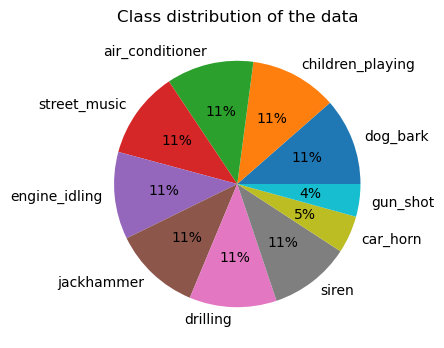

In [3]:
df['class'].value_counts().plot(kind='pie', autopct='%1.0f%%', figsize=(4,4))
plt.title('Class distribution of the data')
plt.ylabel('')
plt.show()

## Feature Extraction and Data Pre-processing 

It was believed that providing the raw data to the models would not yield significant results, even with the capabilities of Deep Learning models. In that sense, to enhance the learning of the models, a step of **Feature Extraction** was undertaken to feed the models processed data that would represent characteristics of the unprocessed data.

Furthermore, performing **Data Pre-Processing** was a necessary step, since the available data is composed  of a multitude of audio samples with different durations,  ranging from just a few milliseconds to 4 seconds of signal, giving the dataset an heterogeneous sample rate.

### Padding Audio Files fo fixed length

Regarding sample rate, all audio data were loaded from the .wav files and resampled to a sample rate of 22050 Hertz. In order to fix the duration of all samples to 4 seconds it was applied zero-padding to the signal until all samples had the same length.

In [4]:
def zero_padded_data_nparray(audios_path, duration_secs = 4, sr = 22050, files_limit = -1, verbose = False):

    files = librosa.util.find_files(audios_path)
    data_array = []

    for index, path_file in enumerate(files):
        if files_limit != -1 and index >= files_limit: break
        
        if verbose:
            print(f"At audio {index+1}/{len(files)}")
            
        signal, sr = librosa.load(path_file, sr = sr, mono=True)
        
        # zero padding
        if len(signal) < duration_secs*sr:
            signal = np.concatenate([
                signal,
                np.zeros(shape = (duration_secs*sr - len(signal), ))
            ])
        elif len(signal) > duration_secs*sr:
            signal = signal[:duration_secs*sr]
            

        if len(signal) == duration_secs*sr:
            lst = path_file.split("\\")
            file_name = lst[-1]
            newrow = [file_name, signal]
            data_array.append(newrow)
        else:
            print(file_name)
            print(path_file) 
        
    return data_array

### Feature extraction -> Log Mel Scaled Spectrograms


For the **LSTM model**, the group decided to used the **log scaled Mel Spectrograms** from the audio files.


A Mel Spectrogram visually depicts the frequency spectrum of an audio signal across time. It illustrates the strength of different frequency components in the audio by employing a colormap for intensity representation. This graphical representation presents audio data in a two-dimensional format, with time on the x-axis, frequency (log(Mel scaled)) on the y-axis, and color intensity indicating the amplitude or energy of each frequency component at distinct time points.


For this model, we decided to use a hop length of 512, and a number of Fast Fourier Transforms of 256.



189895-3-0-0.wav


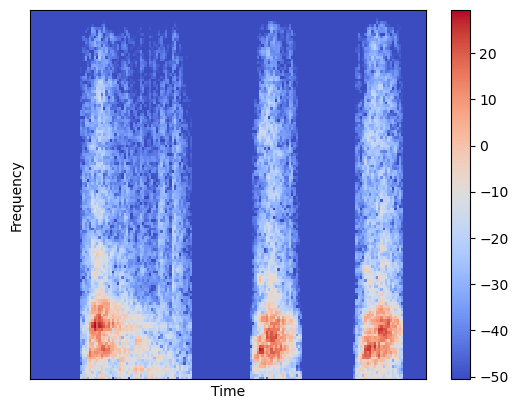

129


In [5]:
# choose a sample to plot
sample_num = 4729

# get the filename
filename = df.slice_file_name[sample_num] 
print(filename)

path = '../UrbanSound8K/audio/fold' + str(df.fold[sample_num]) + '/' + str(filename)
signal, sr = librosa.load(path, sr = 22050)

n_fft = 256
hop_length = 512

stft = librosa.core.stft(signal, hop_length=hop_length, n_fft=n_fft)
spectogram = np.abs(stft)
log_spectogram = librosa.amplitude_to_db(spectogram)

librosa.display.specshow(log_spectogram, sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.show()

print(len(log_spectogram))

Function to extract all Spectrograms:

In [6]:
def get_features(df_in, signals, hop_length = 512, n_fft = 256, sr = 44100):
    
    SPECTOGRAM = [] # list to save Spectograms
    labels = [] # list to save labels
    
    for index in range(len(signals)):

        # get the filename        
        filename = signals[index][0]
        if filename:
            
            # find correspondig row in df_in
            row = df_in.loc[df_in["slice_file_name"] == filename]

            if not row.empty:
                # save labels
                label = row.iloc[0,6] 

                # Extracting Spectograms
                stft = librosa.core.stft(y = np.array(signals[index][1]), 
                                         hop_length = hop_length, 
                                         n_fft =n_fft)
                spectogram = np.abs(stft)
                log_spectogram = librosa.amplitude_to_db(spectogram)

                SPECTOGRAM.append(np.array([log_spectogram]))
                
                # Extracting labels
                labels.append(label)
                
            else: 
                print(f"No matching row for filename {filename}")
        else:
            print("Empty filename")

    # check is features and labels  have the same lenght
    assert len(labels) == len(SPECTOGRAM)

    spec = np.concatenate(SPECTOGRAM, axis = 0)
    return(np.array(spec), labels)

### Data Preprocessing


Regarding data Preprocessing, two different techniques were adopted. Firstly, as a good practice, all data was **normalized**. This step was executed using the MinMaxScaler normalization method implemented by hand, which conveniently scaled all the data to the unit range for each feature's values.


Secondly, the target variable was **One-Hot Encoded**, meaning instead of having only one target column, we now have 10 columns, one for each possible class in the target feature.


To conclude, all data was then saved into **lists of np.Arrays**, to be used in the following model.

In [17]:
fold_paths = ["../UrbanSound8K/audio/fold1/", "../UrbanSound8K/audio/fold2/", "../UrbanSound8K/audio/fold3/",
              "../UrbanSound8K/audio/fold4/", "../UrbanSound8K/audio/fold5/", "../UrbanSound8K/audio/fold6/",
              "../UrbanSound8K/audio/fold7/", "../UrbanSound8K/audio/fold8/", "../UrbanSound8K/audio/fold9/",
              "../UrbanSound8K/audio/fold10/"]

spec = [10]
labels = [10]

for i in range(len(fold_paths)): 
    print(f"Starting fold {i+1}...")

    # Adding Zero-Padding to audio 
    audio = zero_padded_data_nparray(fold_paths[i])

    # Feature Extraction
    spectograms, y = get_features(df, audio)

    # Data Normalization Min-Max scaling to [0, 1] 
    spectograms_scaled = (spectograms - np.min(spectograms)) / (np.max(spectograms) - np.min(spectograms))

    # One-Hot Encoding Target feature
    y_encoded = np.zeros((len(y), max(y) +1))
    y_encoded[np.arange(len(y)), y] = 1

    # Saving Features and Labels to 
    spec.append(np.array(spectograms_scaled))
    labels.append(y_encoded)

    print(f"Done!")

features = spec[1:]
labels = labels[1:]


Starting fold 1...
Done!
Starting fold 2...
Done!
Starting fold 3...
Done!
Starting fold 4...
Done!
Starting fold 5...
Done!
Starting fold 6...
Done!
Starting fold 7...
Done!
Starting fold 8...
Done!
Starting fold 9...
Done!
Starting fold 10...
Done!


## Building the Recurrent Neural Network (LSTM)


The following model topology was the product of much trial and error, given that the group was not following any pre-made architecture.


For all layers, except the output, it was used the **Tanh activation function**. Over time, it gained popularity over the sigmoid function due to its superior performance in multi-layer neural networks. Regarding this project, Tanh activation function provided better results that sigmoid, and relu functions.




### Build Network topology


- **LSTM Layers**


    Firstly, the model strats two LSTM layers, each with 128 neurons. In contrast to a conventional RNN, which features a straightforward structure comprising input, hidden state, and output, an LSTM exhibits a more intricate design. It incorporates additional memory cells and gates, enabling selective retention or omission of information from preceding time steps. The LSTM's capacity to selectively retain or discard information from past time steps renders it highly effective for tasks involving the modeling of long-term dependencies, such as audio classification.


    By adding 'return_sequences = True', the LSTM layers are actually passing on a sequence of values, instead of single values.




- **Time Distributed Layers and Dropout**
   
    Since we are keeping a time dimension returned from LSTM layers, Time Distributed layers results were used to process this extra dimension.
    There are a total 6 Time distributed fully connected Dense Layers. In an attempt to reduce the dimensionality of our data, each subsequent layer possesses fewer neurons, starting at 256, reducing all the way to 8 neurons.


    Furthermore, in an attempt to reduce overfitting, L2 Weight Regularization was implemented in each layer, as well as the addition of 0.3 Dropout rate after each Dense Layer.




- **Flatten Layer**


    After using Time distributed Layers, the output consists of 2 dimensions, therefore to be able to compute one last softmax fully connected layer, we first needed to flatten out these 2 dimensions into 1 cohesive array of values. This is done by using a Flattten Layer.
   


- **Output Layer**


    Finally, the output layer of this neural network will consist of 10 fully connected neurons, since our target feature has 10 different classes. By using the sigmoid function, the output will consist in a probability distribution.


In [8]:
def create_model(x, y):
    input_shape = (x, y) # shape of X_train sample

    model = keras.Sequential()

    # 2 LSTM layers
    model.add(layers.LSTM(128,  input_shape = input_shape, return_sequences = True, activation='relu', kernel_initializer='random_normal'))
    model.add(layers.LSTM(128, return_sequences = True, activation='relu'))
    
    model.add(layers.TimeDistributed(layers.Dense(256, activation = 'relu')))
    model.add(layers.Dropout(0.3))
    model.add(layers.TimeDistributed(layers.Dense(128, activation = 'relu')))
    model.add(layers.Dropout(0.3))
    model.add(layers.TimeDistributed(layers.Dense(64, activation='relu')))
    model.add(layers.Dropout(0.3))
    model.add(layers.TimeDistributed(layers.Dense(32, activation='relu')))
    model.add(layers.Dropout(0.3))
    model.add(layers.TimeDistributed(layers.Dense(16, activation='relu')))
    model.add(layers.Dropout(0.3))
    model.add(layers.TimeDistributed(layers.Dense(8, activation='relu')))

    # Flatten layer 
    model.add(layers.Flatten())

    # Output layer
    model.add(layers.Dense(10, activation = 'softmax'))

    return model

In total, our LSTM conscists of 373,458 different parameters.

In [9]:
model = create_model(129, 173)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 129, 128)          154624    
                                                                 
 lstm_1 (LSTM)               (None, 129, 128)          131584    
                                                                 
 time_distributed (TimeDistr  (None, 129, 256)         33024     
 ibuted)                                                         
                                                                 
 dropout (Dropout)           (None, 129, 256)          0         
                                                                 
 time_distributed_1 (TimeDis  (None, 129, 128)         32896     
 tributed)                                                       
                                                                 
 dropout_1 (Dropout)         (None, 129, 128)          0

We can also plot the graph of the LSTM:

In [10]:
keras.utils.plot_model(model, "model.png", show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


## Metric Variables

To analyse the 10 models made in the 10 fold cross validation, we will keep useful information in an array.

In [11]:
fold_metrics = []

We will also be saving these metrics in Pickle files, for further usage. 
File Load / Save with Pickle:

In [12]:
def save_pkl(data, path):
    with open(path, "wb") as saved_data:
        pickle.dump(data, saved_data)
    saved_data.close()

def load_pkl(path):
    to_return = None
    with open(path, "rb") as loaded_data:
        to_return = pickle.load(loaded_data)
    loaded_data.close()
    return to_return

## 10-Fold Cross Validation


The model will be fit using the **Adam optimizer**, we will use **categorical cross-entropy** (hence why the target label is One-Hot Encoded) as our loss function, and we will use **accuracy** to analyze how well our model performs. We decided to keep the standard **learning rate** of 0.001


During training, the **batch size** will be 64 samples, and, from previous testings, we will defined the **number of epochs** to 60. This number helps us keep a great balance between run-time and overfitting in the model, since adding more epochs takes too much time to train and yields low performance increase.

In [18]:
EPOCHS = 100

for fold in range(10):
    f = "fold" + str(fold+1)
    print("Fold "+str(fold+1)+":")

    X_train, y_train = [], []
    X_test, y_test = [], []
        
    # Splitting the data into Test, Validation and Training sets
    for i in range(10):
        if( i != fold):
            X_train += features[i].tolist()
            y_train.extend(labels[i])
            
        else:
            X_test = features[i]
            y_test = labels[i]

        
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
            
    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.5, random_state = 123)

    # Print sets shapes
    print(f"X_train Shape: {X_train.shape}")
    print(f"X_test Shape: {X_test.shape}")
    print(f"X_val Shape: {X_val.shape}")

    # Create & Compile model
    model = create_model(X_train.shape[1], X_train.shape[2])
    optimizer = keras.optimizers.Adam(learning_rate = 0.00025)
    model.compile(
        optimizer = optimizer, 
        loss = 'categorical_crossentropy', 
        metrics=['accuracy']
    )

    # Train model
    LSTM = model.fit(
        X_train, y_train, 
        epochs = EPOCHS,
        batch_size = 128, 
        shuffle = False, 
        validation_data=(X_val, y_val)
    )

    # Predict unseen data
    y_pred = model.predict(X_test)

    y_pred_reshape = np.argmax(y_pred, axis=1)
    y_test_reshape = np.argmax(y_test, axis=1)
    TestLoss, Testacc = model.evaluate(X_test, y_test)
    
    # Save fold results
    m_metrics = {
        'loss': TestLoss, 
        'accuracy': Testacc, 
        'confusion_matrix': confusion_matrix(y_test_reshape, y_pred_reshape), 
        'history': model, 'history_dict': LSTM.history
    }
    
    fold_metrics.append(m_metrics)

    model.save(f"kfold_metrics_LSTM/model_fold{fold+1}.keras", save_format="keras")
    save_pkl(fold_metrics, "assets/kfold_metrics/metrics.pkl")

    # restart model to avoid memory leakage
    del model 

    print("Done.")


Fold 1:
X_train Shape: (7859, 129, 173)
X_test Shape: (436, 129, 173)
X_val Shape: (437, 129, 173)
129
173
Epoch 1/100
10/62 [===>..........................] - ETA: 39s - loss: 2.3002 - accuracy: 0.1258

KeyboardInterrupt: 

##  Model Analysis

### Accuracy & Loss

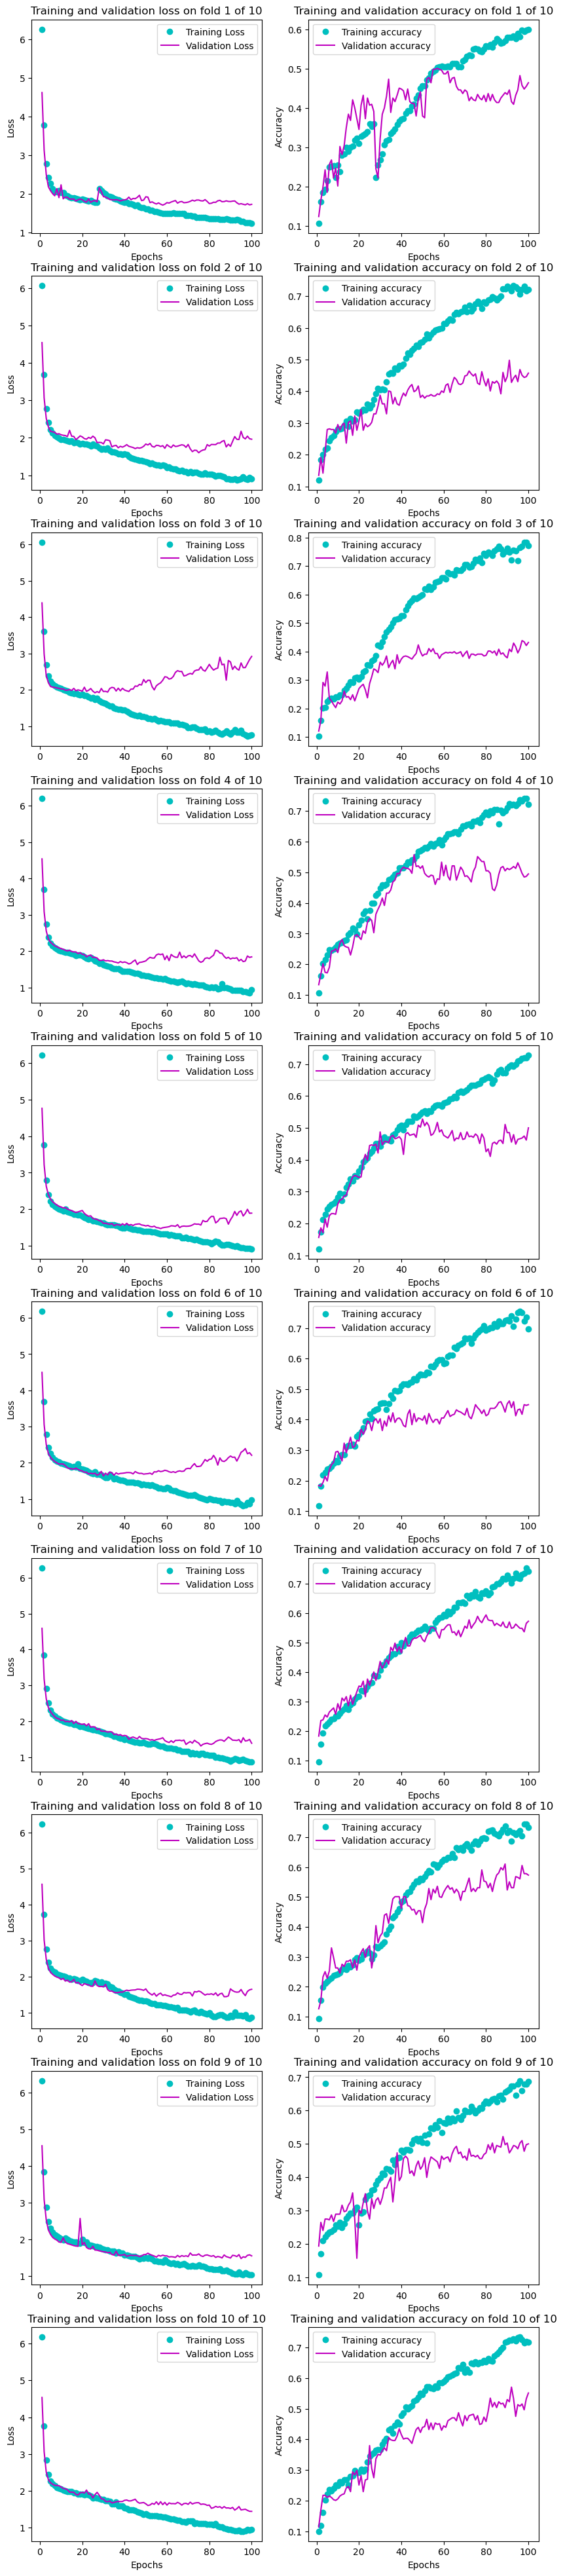

In [ ]:
epochs = range(1, EPOCHS + 1)

fig, ax = plt.subplots(len(fold_metrics), 2, figsize=(10, 5*len(fold_metrics)))

for i in range(0,len(fold_metrics)):
    history_dict = fold_metrics[i].get('history_dict')
    loss_values=history_dict['loss']
    acc_values=history_dict['accuracy']
    val_loss_values = history_dict['val_loss']
    val_acc_values = history_dict['val_accuracy']

    ax[i,0].plot(epochs,loss_values,'co',label='Training Loss')
    ax[i,0].plot(epochs,val_loss_values,'m', label='Validation Loss')
    ax[i,0].set_title('Training and validation loss on fold '+str(i+1)+' of 10')
    ax[i,0].set_xlabel('Epochs')
    ax[i,0].set_ylabel('Loss')
    ax[i,0].legend()

    ax[i,1].plot(epochs,acc_values,'co', label='Training accuracy')
    ax[i,1].plot(epochs,val_acc_values,'m', label='Validation accuracy')
    ax[i,1].set_title('Training and validation accuracy on fold '+str(i+1)+' of 10')
    ax[i,1].set_xlabel('Epochs')
    ax[i,1].set_ylabel('Accuracy')
    ax[i,1].legend()
plt.show()

It's important to acknowledge that since the loss is continuous and the class labels are categorical, there may be seemingly random fluctuations in the validation accuracy. This phenomenon arises because, as the loss decreases, certain classifications might momentarily be assigned incorrectly, even though the model is progressively approaching accurate classifications. This is evident in the "rubber banding" effect, where accuracy catches up with the training loss over additional epochs.

### Average Accuracy and Standard Deviation

In [ ]:
avg_train_acc = 0
train_lst = []
for i in fold_metrics:
    avg_train_acc += max(i.get('history_dict').get('accuracy'))
    train_lst.append(max(i.get('history_dict').get('accuracy')))
    
print("%.4f +- %.4f average train accuracy across all folds." % (avg_train_acc/len(fold_metrics) , np.std(train_lst)))

avg_val_acc = 0
val_lst = []
for i in fold_metrics:
    avg_val_acc += max(i.get('history_dict').get('val_accuracy'))
    val_lst.append(max(i.get('history_dict').get('val_accuracy')))

print("%.4f +- %.4f average validation accuracy across all folds." %(avg_val_acc / len(fold_metrics), np.std(val_lst)))

avg_test_acc = 0
test_lst = []
for i in fold_metrics:
    avg_test_acc += i.get('accuracy')
    test_lst.append(i.get('accuracy'))

print("%.4f +- %.4f average test accuracy across all folds." % (avg_test_acc / len(fold_metrics), np.std(test_lst)))

0.7263 +- 0.0475 average train accuracy across all folds.
0.5281 +- 0.0529 average validation accuracy across all folds.
0.4895 +- 0.0508 average test accuracy across all folds.


We can see that the model provides sufficiently good results, with ~50% accuracy on all training, validation and test sets.

### Confusion Matrix


By computing the confusion matrices of every fold, we obtain similar results. It is noticeable that some folds behaved better than others, but in an overall view, all the models had relatively similar matrices.

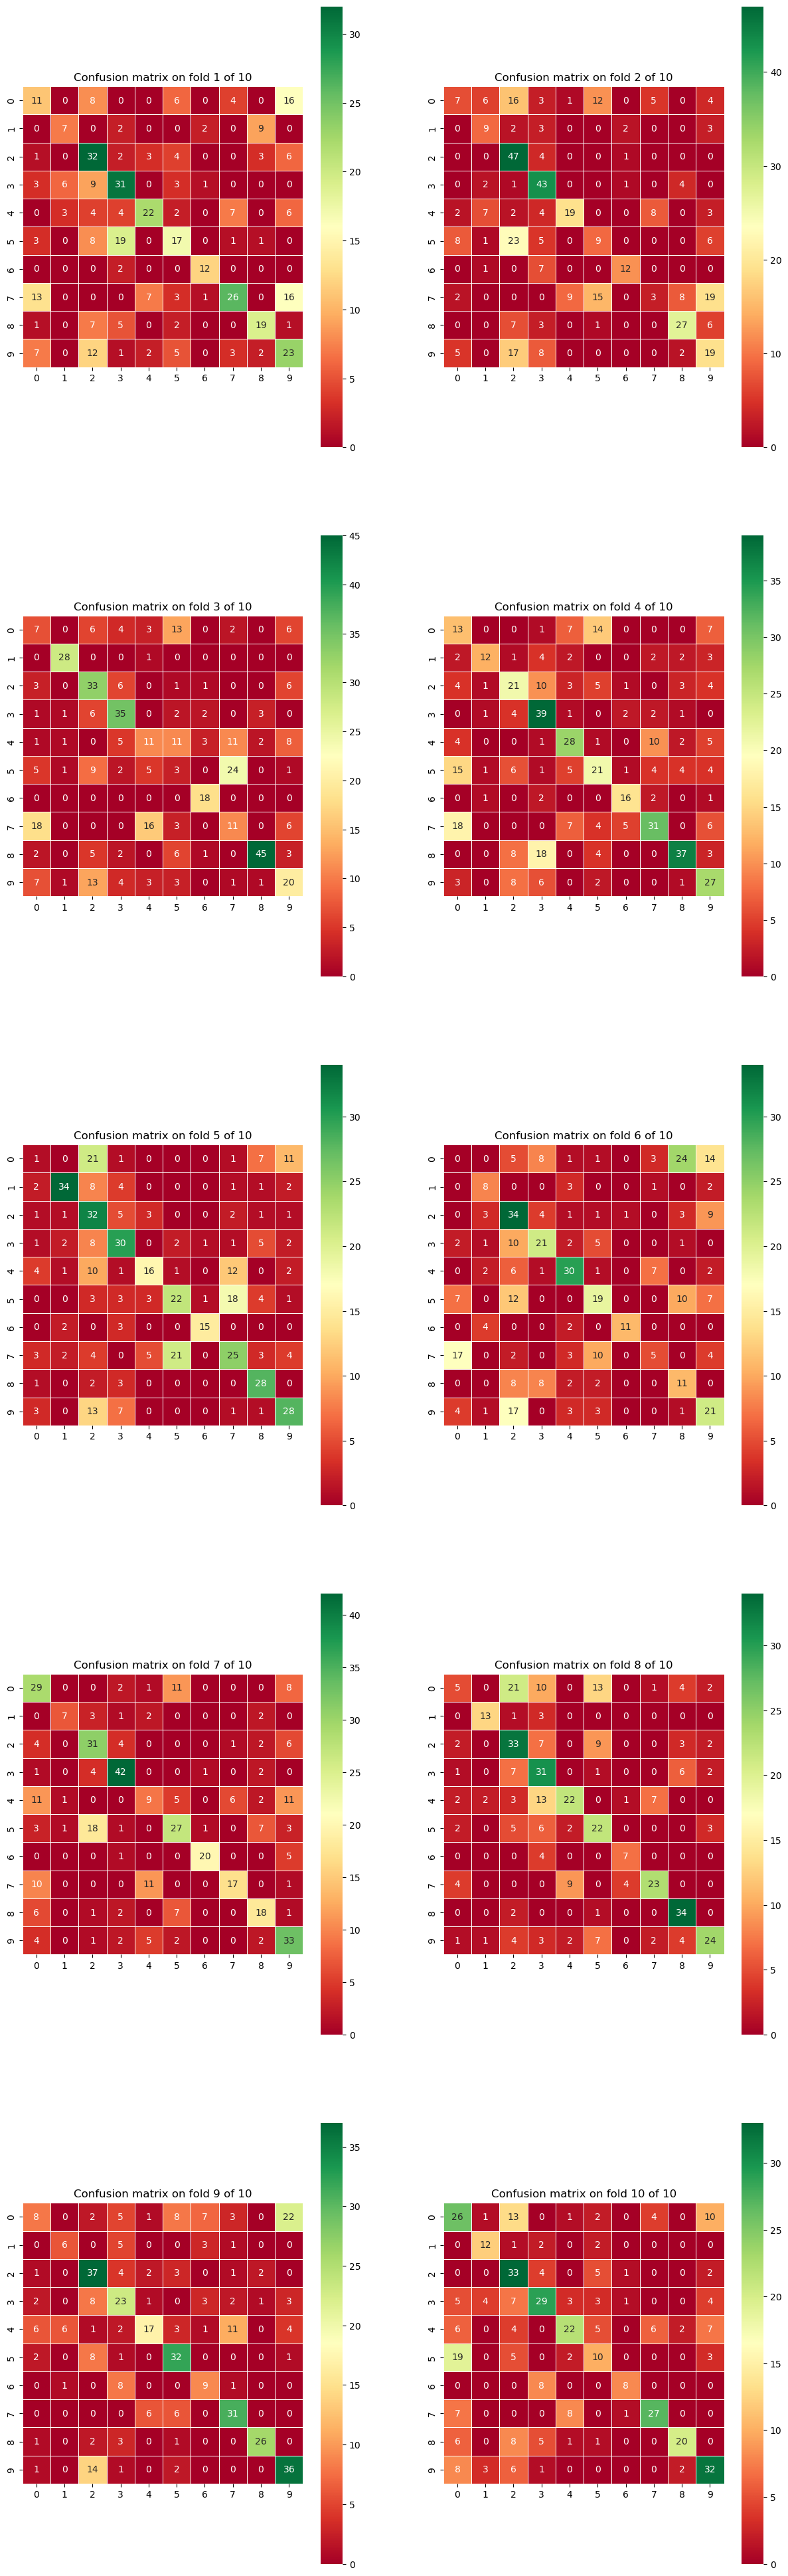

In [ ]:
fig, ax = plt.subplots(5, 2, figsize=(15,5*len(fold_metrics)))

for i in range(0,len(fold_metrics)):
    cm = fold_metrics[i].get('confusion_matrix')
    ax[i//2,i%2].set_title('Confusion matrix on fold '+str(i+1)+' of 10')
    ax[i//2,i%2].set_xlabel('Predicted label')
    ax[i//2,i%2].set_ylabel('Actual label')
    ax[i//2,i%2].invert_yaxis()
    sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'cool', ax=ax[i//2, i%2])

plt.show()


### Sum of all confusion matrices with percentages:

In [ ]:
cm = np.zeros(shape=(10,10))
for i in fold_metrics:
    cm += i.get('confusion_matrix')

cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax =plt.subplots(1, 1, figsize=(10,8))
ax.set_title('Confusion matrix: Sum of all folds')
ax.invert_yaxis()
sns.heatmap(cm, annot=True, fmt=".2%", linewidths=.5, square = True, cmap = 'RdYlGn', ax=ax)

comment on the matrix eheh

## Conclusions



## Further Steps

abah Transfer learning 

## Bibliography & Sources

- Adams, S. (2018). Deep Learning for Audio Classification - YouTube. [online] www.youtube.com. Available at: https://youtube.com/playlist?list=PLhA3b2k8R3t2Ng1WW_7MiXeh1pfQJQi_P&si=WBmycrLWFbnN4SUo [Accessed 20 Nov. 2023].

- Gimeno, P., Viñals, I., Ortega, A., Miguel, A. and Lleida, E. (2020). Multiclass audio segmentation based on recurrent neural networks for broadcast domain data. EURASIP Journal on Audio, Speech, and Music Processing, [online] 2020(1). doi:https://doi.org/10.1186/s13636-020-00172-6.

- Lezhenin, I., Bogach, N. and Pyshkin, E. (2019). Urban Sound Classification using Long Short-Term Memory Neural Network. Proceedings of the 2019 Federated Conference on Computer Science and Information Systems, 18. doi:https://doi.org/10.15439/2019f185.

- Loye, G. (2019). Beginner’s Guide on Recurrent Neural Networks with PyTorch. [online] FloydHub Blog. Available at: https://blog.floydhub.com/a-beginners-guide-on-recurrent-neural-networks-with-pytorch/ [Accessed 27 Nov. 2023].

- Phan, H., Koch, P., Katzberg, F., Maass, M., Mazur, R. and Mertins, A. (2017). Audio Scene Classification with Deep Recurrent Neural Networks. [online] Available at: https://arxiv.org/pdf/1703.04770.pdf [Accessed 26 Nov. 2023].

- Salamon, J. (2019). UrbanSound8K. [online] Urban Sound Datasets. Available at: https://urbansounddataset.weebly.com/urbansound8k.html [Accessed 30 Oct. 2023].

- Team, K. (n.d.). Keras documentation: Keras layers API. [online] keras.io. Available at: https://keras.io/api/layers/ [Accessed 20 Nov. 2023].Vaj, T. (2023). 

- MFCC vs Mel Spectrogram. [online] Medium. Available at: https://vtiya.medium.com/mfcc-vs-mel-spectrogram-8f1dc0abbc62 [Accessed 28 Nov. 2023].

- Velardo , V. (2020). Deep Learning (for Audio) with Python. [online] www.youtube.com. Available at: https://www.youtube.com/watch?v=fMqL5vckiU0&list=PL-wATfeyAMNrtbkCNsLcpoAyBBRJZVlnf&pp=iAQB [Accessed 26 Nov. 2023].